<a href="https://colab.research.google.com/github/Josh-XS/Sales-predictions/blob/main/Sales_Predictions_with_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sales Predictions with Machine Learning

Joshua Nickell

## Imports

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

# models/metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib

import os
os.makedirs("images/", exist_ok=True)

SEED = 321
np.random.seed(SEED)

from sklearn import set_config
set_config(display='diagram')

## Functions

In [2]:
def evaluate_regression(model, X_train,y_train, X_test, y_test): 
    """Evaluates a scikit learn regression model using r-squared and RMSE"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = r2_score(y_train, y_pred_train)
    rmse_train = mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    
    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")
        
    
    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = r2_score(y_test, y_pred_test)
    rmse_test = mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    
    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")


In [3]:
def get_coefficients(model, feature_names = None, sort=True,ascending=True,
                     name='LinearRegression Coefficients'):
    if feature_names is None:
        feature_names = lin_reg.feature_names_in_
    ## Saving the coefficients
    coeffs = pd.Series(lin_reg.coef_, index= feature_names)
    coeffs['intercept'] = lin_reg.intercept_
    if sort==True:
        coeffs = coeffs.sort_values(ascending=ascending)
    return coeffs

In [4]:
def annotate_hbars(ax, ha='left',va='center',size=12,  xytext=(4,0),
                  textcoords='offset points'):
    for bar in ax.patches:
    
        ## calculate center of bar
        bar_ax = bar.get_y() + bar.get_height()/2
        ## get the value to annotate
        val = bar.get_width()
        if val < 0:
            val_pos = 0
        else:
            val_pos = val
        # ha and va stand for the horizontal and vertical alignment
        ax.annotate(f"{val:.3f}", (val_pos,bar_ax), ha=ha,va=va,size=size,
                        xytext=xytext, textcoords=textcoords)

In [5]:
def plot_coeffs(coeffs, top_n=None,  figsize=(4,5), 
                intercept=False,  intercept_name = "intercept", 
                annotate=False, ha='left',va='center', size=12, 
                xytext=(4,0), textcoords='offset points'):
    """ Plots the top_n coefficients from a Series, with optional annotations.
    """
    # Drop intercept if intercept=False and 
    if (intercept==False) & ( intercept_name in coeffs.index):
        coeffs = coeffs.drop(intercept_name)
    if top_n==None:
        ## sort all features and set title
        plot_vals = coeffs#.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        
        ## sort features and keep top_n and set title
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        title = f"Top {top_n} Largest Coefficients"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient', 
            ylabel='Feature Names', 
            title=title)
    ax.axvline(0, color='k')
    if annotate==True:
        annotate_hbars(ax, ha=ha,va=va,size=size,xytext=xytext, textcoords=textcoords)
    return ax

In [6]:
def get_importances(model, feature_names=None,name='Feature Importance',
                   sort=False, ascending=True):
    
    ## checking for feature names
    if feature_names == None:
        feature_names = model.feature_names_in_
        
    ## Saving the feature importances
    importances = pd.Series(model.feature_importances_, index= feature_names,
                           name=name)
    
    # sort importances
    if sort == True:
        importances = importances.sort_values(ascending=ascending)
        
    return importances

In [7]:
def plot_importance(importances, top_n=None,  figsize=(8,6)):
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Importance',
            ylabel='Feature Names',
            title=title)
    ## return ax in case want to continue to update/modify figure
    return ax

## Loading Data

In [8]:
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vR0TKEXKL-l0SVSGCehXIONnm0wttSHcPqgVceF7dUXcrrk1ClRQXGNCDFm0qWIfNrbCV6uuXWxh9P5/pub?gid=1274198617&single=true&output=csv')

In [9]:
#load the data
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [10]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


## Data Cleaning

### Identify Duplicates

In [11]:
df.duplicated().sum()

0

There are no duplicates.

### Drop Unnescesary Columns

In [12]:
df.drop(columns = ['Item_Identifier','Outlet_Identifier','Outlet_Establishment_Year'], axis = 1, inplace = True)
df.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,Low Fat,0.016047,Dairy,249.8092,Medium,Tier 1,Supermarket Type1,3735.1380
1,5.92,Regular,0.019278,Soft Drinks,48.2692,Medium,Tier 3,Supermarket Type2,443.4228
2,17.50,Low Fat,0.016760,Meat,141.6180,Medium,Tier 1,Supermarket Type1,2097.2700
3,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,NaN,Tier 3,Grocery Store,732.3800
4,8.93,Low Fat,0.000000,Household,53.8614,High,Tier 3,Supermarket Type1,994.7052


These 3 columns would have no impact on our target, which is why they were dropped.

### Check For Inconsistencies

I need to create a loop to find any inconsistencies in the columns.

In [13]:
cols = df.dtypes.index
for col in cols:
    print(f'- {col}:')
    print(df[col].value_counts(dropna=False))
    print("\n\n")

- Item_Weight:
NaN       1463
12.150      86
17.600      82
13.650      77
11.800      76
          ... 
7.275        2
7.685        1
9.420        1
6.520        1
5.400        1
Name: Item_Weight, Length: 416, dtype: int64



- Item_Fat_Content:
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64



- Item_Visibility:
0.000000    526
0.076975      3
0.162462      2
0.076841      2
0.073562      2
           ... 
0.013957      1
0.110460      1
0.124646      1
0.054142      1
0.044878      1
Name: Item_Visibility, Length: 7880, dtype: int64



- Item_Type:
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others     

### Fix Inconsistencies

In [14]:
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('LF', 'Low Fat')

In [15]:
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('low fat', 'Low Fat')

In [16]:
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('reg', 'Regular')

In [17]:
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

### Ordinal Encoding

One of our categorical columns is ordinal, so I have decided to change it before splitting the data.

In [18]:
df['Outlet_Size'].replace({'Small':0,'Medium':1,'High':2}, inplace=True)
df['Outlet_Size'].value_counts()

1.0    2793
0.0    2388
2.0     932
Name: Outlet_Size, dtype: int64

## Pre-Processing

### Splitting the Data

In [19]:
#split data
X = df.drop(columns = 'Item_Outlet_Sales')
y = df['Item_Outlet_Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [20]:
len(X_train)

6392

In [21]:
len(X_test)

2131

In [22]:
len(y_train)

6392

In [23]:
len(y_test)

2131

### Creating Pipelines

In [24]:
#create categorical and numerical selectors
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

In [25]:
## using our cat_sel to get the list of categorical features
cat_selector(X)

for col in cat_selector(X):
    print(f"For {col}:\n{X[col].unique()}\n")

For Item_Fat_Content:
['Low Fat' 'Regular']

For Item_Type:
['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']

For Outlet_Location_Type:
['Tier 1' 'Tier 3' 'Tier 2']

For Outlet_Type:
['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']



In [26]:
#create categorical and numerical imputers
mf_imputer = SimpleImputer(strategy='most_frequent')
mean_imputer= SimpleImputer(strategy='mean')
#create scaler for numerical values
scaler = StandardScaler()
#create onehotencoder for nominal values
drop_cats = ['Regular','Others','Tier 3','Grocery Store']
ohe = OneHotEncoder(drop=drop_cats, sparse=False)

In [27]:
#create numerical pipeline
num_pipeline = make_pipeline(mean_imputer, scaler)
num_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [28]:


#create categorical pipeline
cat_pipeline = make_pipeline(mf_imputer, ohe)
cat_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder',
                 OneHotEncoder(drop=['Regular', 'Others', 'Tier 3',
                                     'Grocery Store'],
                               sparse=False))])

### Creating the Column Transformer

In [29]:
#create tuples for numeric and categorical processors
nums = (num_pipeline, num_selector)
cats = (cat_pipeline, cat_selector)
#create column transformer with tuples
preprocessor = make_column_transformer(nums, cats, verbose_feature_names_out=False)

In [30]:
#fit the column transformer on training data only
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
feature_names

array(['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Size',
       'Item_Fat_Content_Low Fat', 'Item_Type_Baking Goods',
       'Item_Type_Breads', 'Item_Type_Breakfast', 'Item_Type_Canned',
       'Item_Type_Dairy', 'Item_Type_Frozen Foods',
       'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks',
       'Item_Type_Health and Hygiene', 'Item_Type_Household',
       'Item_Type_Meat', 'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
       'Outlet_Location_Type_Tier 1', 'Outlet_Location_Type_Tier 2',
       'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2',
       'Outlet_Type_Supermarket Type3'], dtype=object)

In [31]:
#create a dataframe for x train
X_train_df = pd.DataFrame(preprocessor.transform(X_train),columns = feature_names, index = X_train.index)
X_train_df.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Size,Item_Fat_Content_Low Fat,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,...,Item_Type_Meat,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
4776,0.817249,-0.712775,1.828109,0.407785,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7510,0.556340,-1.291052,0.603369,0.407785,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5828,-0.131512,1.813319,0.244541,0.407785,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
5327,-1.169219,-1.004931,-0.952591,-1.291630,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4810,1.528819,-0.965484,-0.336460,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [32]:
#create a dataframe for x test
X_test_df = pd.DataFrame(preprocessor.transform(X_test),columns = feature_names, index = X_test.index)
X_test_df.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Size,Item_Fat_Content_Low Fat,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,...,Item_Type_Meat,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
7503,3.310089e-01,-0.776646,-0.998816,2.107200,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2957,-1.179892e+00,0.100317,-1.585194,-1.291630,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
7031,3.784469e-01,-0.482994,-1.595784,0.407785,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1084,4.213344e-16,-0.415440,0.506592,0.407785,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
856,-6.426567e-01,-1.047426,0.886725,-1.291630,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


## Creating the Models

### Linear Regression

In [33]:
#create and evaluate linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_df,y_train)
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 0.56	RMSE= 1140.39
Test Data:	R^2= 0.57	RMSE= 1094.59


In [34]:
#getting the coefficients
lr_coeffs = get_coefficients(lin_reg)
pd.set_option('display.float_format', lambda x: f"{x:,.2f}")
lr_coeffs

Item_Type_Dairy                     -74.33
Item_Fat_Content_Low Fat            -63.11
Item_Visibility                     -21.67
Outlet_Location_Type_Tier 1         -11.20
Item_Type_Soft Drinks               -10.46
Item_Weight                          -7.39
Outlet_Location_Type_Tier 2          -6.44
Outlet_Size                           1.07
Item_Type_Breads                      1.95
Item_Type_Snack Foods                10.99
Item_Type_Meat                       22.20
Item_Type_Frozen Foods               29.52
Item_Type_Baking Goods               31.74
Item_Type_Household                  35.01
Item_Type_Hard Drinks                41.74
Item_Type_Canned                     57.82
Item_Type_Health and Hygiene         58.19
Item_Type_Fruits and Vegetables      75.12
Item_Type_Starchy Foods              76.57
Item_Type_Breakfast                  78.60
Item_Type_Seafood                   350.05
intercept                           391.57
Item_MRP                            984.39
Outlet_Type

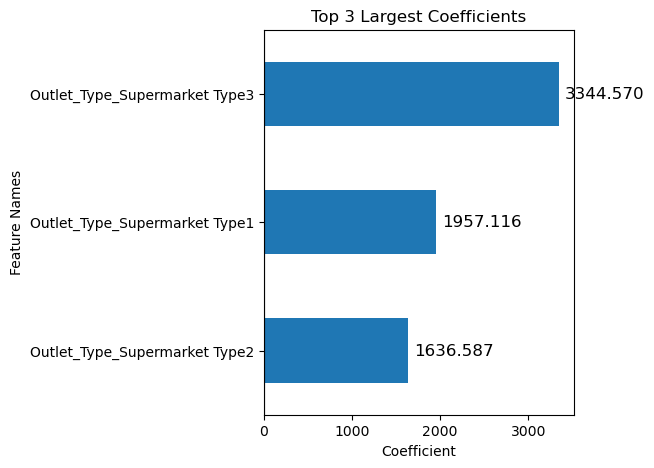

In [35]:
plot_coeffs(lr_coeffs, top_n=3, annotate=True);
plt.savefig('images/LinearRegression.png', dpi=500, bbox_inches='tight')

It seems that the three most impactful features happen to be the type of store.

### Descision Tree Regressor

In [36]:
#create decision tree regressor
dec_tree = DecisionTreeRegressor(random_state = SEED, max_depth=5)
dec_tree.fit(X_train_df,y_train)
evaluate_regression(dec_tree, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 0.61	RMSE= 1071.49
Test Data:	R^2= 0.59	RMSE= 1069.13


In [37]:
## testing our function
importances = get_importances(dec_tree,sort=True,ascending=False,
                              name="Descision Tree Importances")
importances

Item_MRP                          0.55
Outlet_Type_Supermarket Type3     0.18
Outlet_Type_Supermarket Type1     0.16
Outlet_Type_Supermarket Type2     0.11
Item_Visibility                   0.00
Item_Type_Breakfast               0.00
Outlet_Size                       0.00
Item_Fat_Content_Low Fat          0.00
Item_Type_Health and Hygiene      0.00
Item_Type_Seafood                 0.00
Outlet_Location_Type_Tier 2       0.00
Outlet_Location_Type_Tier 1       0.00
Item_Type_Starchy Foods           0.00
Item_Type_Soft Drinks             0.00
Item_Type_Snack Foods             0.00
Item_Weight                       0.00
Item_Type_Meat                    0.00
Item_Type_Household               0.00
Item_Type_Fruits and Vegetables   0.00
Item_Type_Frozen Foods            0.00
Item_Type_Dairy                   0.00
Item_Type_Canned                  0.00
Item_Type_Breads                  0.00
Item_Type_Baking Goods            0.00
Item_Type_Hard Drinks             0.00
Name: Descision Tree Impo

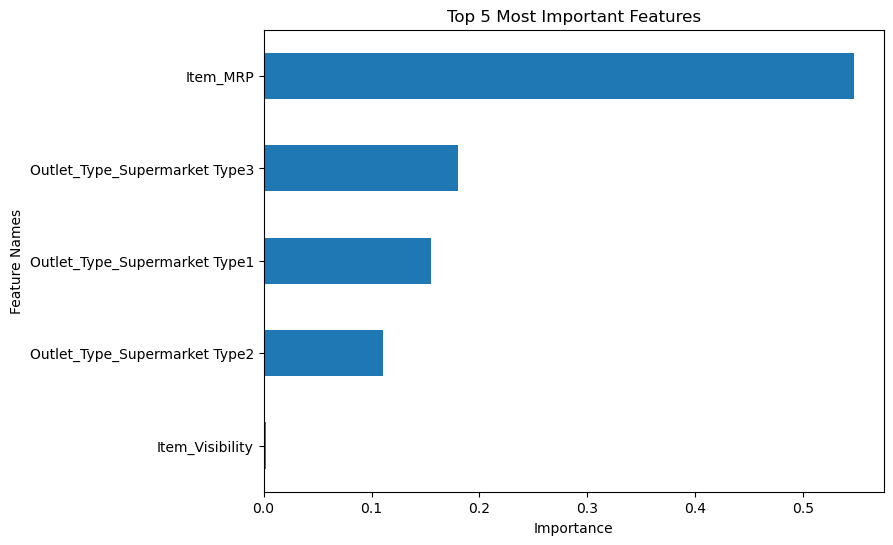

In [38]:
plot_importance(importances,top_n=5);
plt.savefig('images/DecisionTree.png', dpi=300, bbox_inches='tight')

The five most important features appear to also include the store type, but item MRP is 

## Saving with Joblib

In [39]:
## creating a dictionary of all of the variables to save for later
export = {'X_train':X_train,
         'y_train': y_train,
         'X_test':X_test,
          "y_test": y_test,
         'preprocessor':preprocessor,
         'LinearRegression':lin_reg,
         'DecisionTree':dec_tree}
joblib.dump(export, 'sales_models.joblib')

['sales_models.joblib']